In [1]:

# coding: utf-8

# In[65]:


from lxml import etree
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np



# In[41]:


datamap=OrderedDict()
datamap["android"]="android.stackexchange.com"
datamap["dba"]="dba.stackexchange.com"
datamap["softwareEng"]="softwareengineering.stackexchange.com"
datamap["serverfault"]= "serverfault.com"
datamap["superuser"]="superuser.com"
datamap["stackoverflow"]="stackoverflow.com-"


# In[59]:


def read_tags(filename):
    logtags=[]
    for row in open(filename,"r"):
        logtags.append(row.split(",")[0].strip().lower())   
    return logtags

def read_prog_lang(filename):
    data=OrderedDict()
    f=open(filename,"r")
    for l in f:
        row=l.split("\t")
        key=row[0].lower().strip()
        data[key]=[]
        for element in row[1].split(","):
            data[key].append(element.strip().lower())
    return data

def atleast_one(a, b):
    return not set(a).isdisjoint(b)

def refine_tags(tags):
    if tags!=None:
        l=tags.split('><')
        l=[i.replace('>','').replace('<','').lower() for i in l]
        return l
    else:
        return ["???"]

def init_data(taglist):
    data=OrderedDict()
    for tag in taglist:
        data[tag]=OrderedDict()
        for fname in datamap:
            data[tag][fname]=0
    return data


# In[49]:


logtags=list(set(read_tags("logging - Sheet3.csv")))

prog_tags=read_prog_lang("logging - Sheet4.tsv")

for i in prog_tags:
    logtags.extend(prog_tags[i])
logtags=list(set(logtags))

# del logtags[logtags.index("")]


# In[57]:


def common_tag_csv(data):
    f=open("Sheet-2.csv","w")
    f.write(",")
    for fname in datamap:
        f.write(fname+",")
    f.write("\n")
    for tag in data:
        f.write(tag+",")
        for element in data[tag]:
            f.write(str(data[tag][element])+",")
        f.write("\n")
    f.close()
    
    fr=open("Sheet-2.csv","r")
    fw=open("Modified-Sheet-2.csv","w")
    fw.write(fr.readline())
    for l in fr:
        row=l.split(",")
        temp=Counter(row)
        print(temp)
        if temp['0'] <=4:
            fw.write(l)
    fw.close()
    fr.close()
        
        


# In[51]:


def count_tags(taglist):
    data=init_data(taglist)
    #print(data)
    for fname in datamap:
        print(fname)
        if fname=="stackoverflow" and datamap[fname]=="stackoverflow.com-":
            datamap[fname]=datamap[fname]+"Tags"
        f=open("data/"+datamap[fname]+"/Tags.xml","rb")
        next(f)
        next(f)
        count=0
        for l in f:
            try:
                rows=etree.XML(l)  
                if  rows.get("TagName").lower() in taglist:
                    tagname=rows.get("TagName").lower()
                    question=rows.get("Count")
                    data[tagname][fname]=question
                    count=count+int(question)
                    #print(tagname,question)
            except:
                print(l)
               

        print(count)
    return data


# In[58]:


# data=count_tags(logtags)
# common_tag_csv(data)


# In[66]:


def plot_monthly_bargraph(plt,data,title,label,opr):
    # plt.close()
    # plt.clf()
    if opr==1:
        color='b'
    else:
        color='g'
    y=[data[i] for i in data]
    x=[i for i in range(len(data))]
    xticks=[i.split('-')[0] for i in data]
    plt.bar(x,y,label=label,color=color)
    gap=1
    plt.xticks(x[::gap],xticks[::gap],rotation=30)
    #plt.title(title.upper())
    plt.ylabel("No. of Questions")
    return plt
    # if opr==1:
    #     plt.savefig("Images/"+title+".png")
    # else:
    #     plt.show()
    # plt.clf()

    
def plot_monthly_cumgraph(plt,data,title,label,opr):
    if opr==1:
        color='b'
        marker=","
    else:
        color='g'
        marker="o"
    y=np.cumsum([data[i] for i in data])
    x=[i for i in range(len(data))]
    xticks=[i.split('-')[0] for i in data]
    plt.plot(x,y,color=color)
    plt.scatter(x,y,marker=marker,label=label,color=color)
    gap=1
    plt.xticks(x[::gap],xticks[::gap],rotation=30)
    #plt.title(title.upper())
    plt.ylabel("No. of Questions")
    # if opr==1:
    #     plt.savefig("Images/"+title+".png")
    # else:
    #     plt.show()
    # plt.clf()
    return plt

def init_o_data():
    data=OrderedDict()
    start_year=2008
    start_month=8
    end_year=2017
    end_month=12
    month=1
    for year in range(start_year,end_year+1):
       # for month in range(start_month,end_month+1):
            #print(year,month)
            temp=str(month)
            if len(temp)==1:
                temp="0"+temp
            data[str(year)]=[]
        #start_month=1
    return data


# In[61]:


def distribute_posts(website,logtags):
    if fname=="stackoverflow" and datamap[fname]=="stackoverflow.com-":
        datamap[fname]=datamap[fname]+"Posts"   
    
    f=open("data/"+datamap[website]+"/Posts.xml","rb")
    next(f)
    next(f)
    data=init_o_data()
    data_all=init_o_data()
    count=0
    for l in f:
        try:
            row=etree.XML(l)      
            posttypeid=row.get("PostTypeId") 
            acceptedanswerID=row.get("AcceptedAnswerId")
            if posttypeid=="1":
                tags=refine_tags(row.get("Tags"))
                if atleast_one(tags,logtags):
                        date=row.get("CreationDate")
                        key=date.split("T")[0][0:4]
                        if key not in data_all:
                            data_all[key]=[]
                        data_all[key].append(int(row.get("AnswerCount")))
            
            if posttypeid=="1" and acceptedanswerID!=None:
                # Means it has an accepted answer
                
                if atleast_one(tags,logtags):
                    # Atleast one logging tag

                    #print(tags)
                    date=row.get("CreationDate")
                    key=date.split("T")[0][0:4]
                    if key not in data:
                        data[key]=[]
                    data[key].append(int(row.get("AnswerCount")))
        except:
            print(l)
    return data, data_all


# In[68]:


for fname in list(datamap.keys()):
   
    data, data_all=distribute_posts(fname,logtags)
    pickle.dump(data,open(fname+".anscount.pickle","wb"))
    pickle.dump(data_all,open(fname+".anscount.all.pickle","wb"))



b'</posts>'
b'</posts>'
b'</posts>'
b'</posts>'
b'</posts>'
b'</posts>'


nan nan nan nan nan
nan nan nan nan nan
3.0 7.0 4.0 5.0 6.0
0.0 3.0 1.0 2.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 0.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0
0.0 2.0 0.0 1.0 1.0
0.0 2.0 0.0 1.0 1.0
0.0 1.0 0.0 0.0 0.5


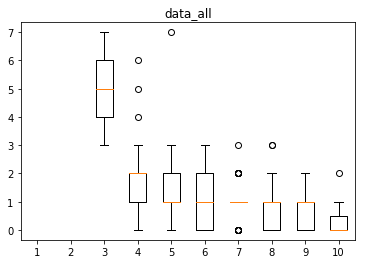

nan nan nan nan nan
nan nan nan nan nan
nan nan nan nan nan
1.0 3.0 1.0 2.0 2.0
1.0 3.0 1.0 2.0 2.0
1.0 2.0 1.5 2.0 2.0
1.0 1.0 1.0 1.0 1.0
1.0 2.0 1.0 1.0 1.5
1.0 1.0 1.0 1.0 1.0
nan nan nan nan nan


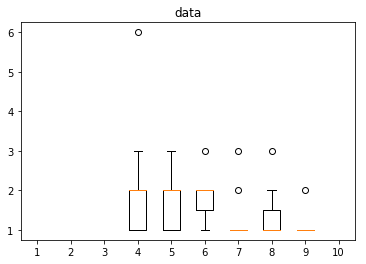

nan nan nan nan nan
4.0 4.0 4.0 4.0 4.0
nan nan nan nan nan
1.0 6.0 1.0 2.0 3.0
0.0 3.0 1.0 2.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0
1.0 1.25 1.0 1.0 1.25


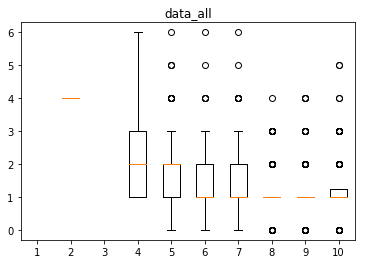

nan nan nan nan nan
4.0 4.0 4.0 4.0 4.0
nan nan nan nan nan
1.0 6.0 1.0 2.0 3.0
1.0 3.0 1.0 2.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0


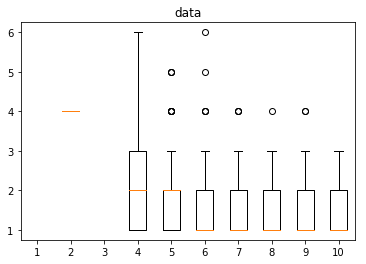

nan nan nan nan nan
nan nan nan nan nan
2.0 6.0 3.5 5.0 5.5
1.0 7.0 2.0 3.0 4.5
1.0 7.0 1.0 2.5 4.0
1.0 3.0 1.0 2.0 2.0
0.0 5.0 1.0 2.0 3.0
0.0 6.0 1.0 2.0 3.0
0.0 4.0 1.0 2.0 3.0
0.0 3.0 1.0 2.0 2.0


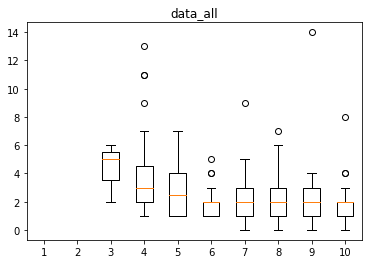

nan nan nan nan nan
nan nan nan nan nan
2.0 5.0 2.75 3.5 4.25
2.0 5.0 3.0 3.0 4.0
1.0 7.0 2.0 3.0 4.0
2.0 2.0 2.0 2.0 2.0
1.0 5.0 1.0 2.0 3.0
1.0 7.0 2.0 2.5 4.25
1.0 3.0 1.25 2.0 2.75
1.0 3.0 1.0 2.0 2.0


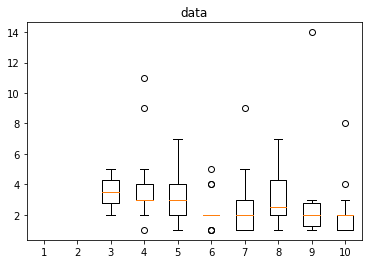

nan nan nan nan nan
0.0 7.0 2.0 3.0 4.0
0.0 6.0 1.0 2.0 3.0
0.0 3.0 1.0 2.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0
0.0 2.0 0.0 1.0 1.0


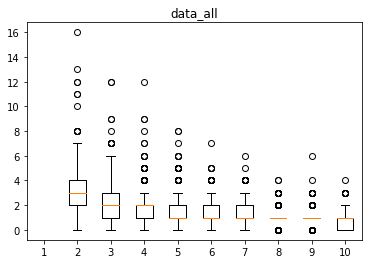

nan nan nan nan nan
1.0 7.0 2.0 3.0 4.0
1.0 6.0 1.0 2.0 3.0
1.0 3.0 1.0 2.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0


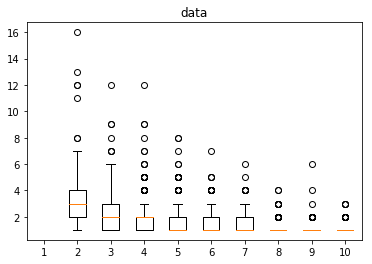

nan nan nan nan nan
0.0 6.0 2.0 2.0 3.75
0.0 6.0 1.0 2.0 3.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0
0.0 2.0 0.0 1.0 1.0
0.0 2.0 0.0 0.0 1.0


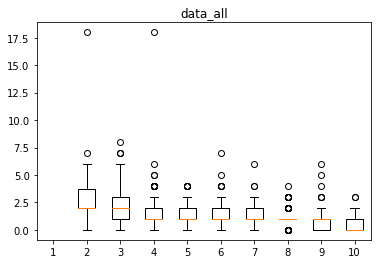

nan nan nan nan nan
1.0 4.0 2.0 2.0 3.0
1.0 6.0 1.0 2.0 3.0
1.0 6.0 1.0 2.0 3.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0


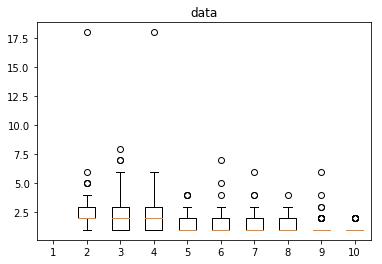

0.0 12.0 2.0 4.0 6.0
0.0 7.0 2.0 2.0 4.0
0.0 6.0 1.0 2.0 3.0
0.0 3.0 1.0 2.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
0.0 3.0 1.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0
0.0 2.0 0.0 1.0 1.0


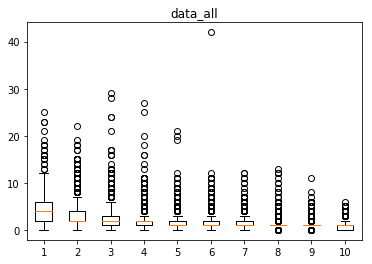

1.0 12.0 2.0 4.0 6.25
1.0 7.0 2.0 3.0 4.0
1.0 6.0 1.0 2.0 3.0
1.0 6.0 1.0 2.0 3.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 3.0 1.0 1.0 2.0
1.0 1.0 1.0 1.0 1.0


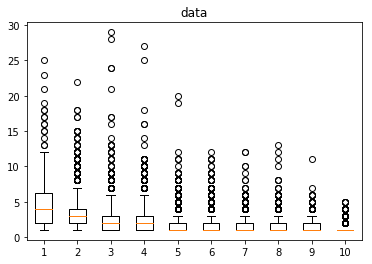

In [29]:
ym={"1":"2008","2":"2009","3":"2010","4":"2011","5":"2012","6":"2013","7":"2014","8":"2015","9":"2016","10":"2017"}

def boxplt(data,fname,title,opr):
    plt.boxplot([data[i] for i in data])
    plt.xticks([i for i in range(len())])
    plt.show()

    
def get_boxplot(data):
    if len(data)>0:
        
        maxx=max(data)
        minx=min(data)
        q1=np.percentile(data,0.25)
        q2=np.percentile(data,0.5)
        q3=np.percentile(data,0.75)
        info=[maxx,minx,q1,q2,q3]
        return [str(i) for i in info]
    else:
        return ["None","None","None","None","None"]
    
f=open("data_all.csv","w")
f2=open("data_accepted.csv","w")
f.write("website,year,min,max,q1,q2,q3\n")
f2.write("website,year,min,max,q1,q2,q3\n")
for fname in list(datamap.keys()):
    c=1
    data=pickle.load(open(fname+".anscount.pickle","rb"))
    data_all=pickle.load(open(fname+".anscount.all.pickle","rb"))
    bp=plt.boxplot([data_all[i] for i in data_all])
   
    for m,m2,i in zip(bp['boxes'],bp['medians'],range(0,len(bp['caps']),2)):
        ldata=m.get_ydata()
        q3=ldata[2]
        q1=ldata[0]
        med=m2.get_ydata()[0]   
        minx=bp['caps'][i].get_ydata()[0]
        maxx=bp['caps'][i+1].get_ydata()[0]
        print(minx,maxx,q1,med,q3)
        boxinfo=[minx,maxx,q1,med,q3]
        f.write(fname+","+ym[str(c)]+","+str(",".join([str(i) for i in boxinfo]))+"\n")
        c+=1
      
    c=1
    plt.title("data_all")
    plt.show()
    bp=plt.boxplot([data[i] for i in data])
    for m,m2,i in zip(bp['boxes'],bp['medians'],range(0,len(bp['caps']),2)):
        ldata=m.get_ydata()
        q3=ldata[2]
        q1=ldata[0]
        med=m2.get_ydata()[0]   
        minx=bp['caps'][i].get_ydata()[0]
        maxx=bp['caps'][i+1].get_ydata()[0]
        print(minx,maxx,q1,med,q3)
        boxinfo=[minx,maxx,q1,med,q3]
        f2.write(fname+","+ym[str(c)]+","+",".join([str(i) for i in boxinfo])+"\n")
        c=c+1
    plt.title("data")
    plt.show()
f.close()
f2.close()

In [1]:

from lxml import etree
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import pandas as pd


# In[41]:


datamap=OrderedDict()
datamap["android"]="android.stackexchange.com"
datamap["dba"]="dba.stackexchange.com"
datamap["softwareEng"]="softwareengineering.stackexchange.com"
datamap["serverfault"]= "serverfault.com"
datamap["superuser"]="superuser.com"
datamap["stackoverflow"]="stackoverflow.com-"

In [6]:
for m in bp['boxes']:
    ldata=m.get_ydata()
    median=ldata[0]
    print(ldata)

[ 2.  2.  6.  6.  2.]
[ 2.  2.  4.  4.  2.]
[ 1.  1.  3.  3.  1.]
[ 1.  1.  2.  2.  1.]
[ 1.  1.  2.  2.  1.]
[ 1.  1.  2.  2.  1.]
[ 1.  1.  2.  2.  1.]
[ 1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.]
[ 0.  0.  1.  1.  0.]


In [17]:
bp['caps'][1].get_ydata()

array([ 12.,  12.])

In [11]:
df=pd.DataFrame(data_all['2017'])
print(df.describe())
print(max(data_all['2017']))

                  0
count  11030.000000
mean       0.793744
std        0.749272
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        6.000000
6


In [7]:
data_all

OrderedDict([('2008',
              [8,
               4,
               2,
               5,
               6,
               2,
               7,
               6,
               1,
               2,
               10,
               8,
               3,
               1,
               3,
               10,
               4,
               7,
               4,
               4,
               7,
               7,
               6,
               10,
               2,
               6,
               7,
               7,
               7,
               4,
               2,
               3,
               2,
               6,
               6,
               7,
               12,
               2,
               5,
               1,
               5,
               3,
               2,
               19,
               3,
               10,
               6,
               14,
               4,
               3,
               3,
               10,
               5,
               2

In [8]:
bp.keys()

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])